In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import cuml

from cuml.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier#Random forest powered by gpu
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn") #Ignore seaborn warnings

# EDA

In [42]:
#Data loading
df = pd.read_csv('/kaggle/input/credit-fraud-detection/creditcard_2023.csv')
df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


In [43]:
credit_card=df.copy()
credit_card.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [44]:
credit_card.shape

(568630, 31)

In [45]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [46]:
credit_card.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [47]:
credit_card.dropna(inplace=True)
credit_card.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [48]:
credit_card.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [49]:
credit_card.duplicated().sum()

0

In [50]:
credit_card['Class'].value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

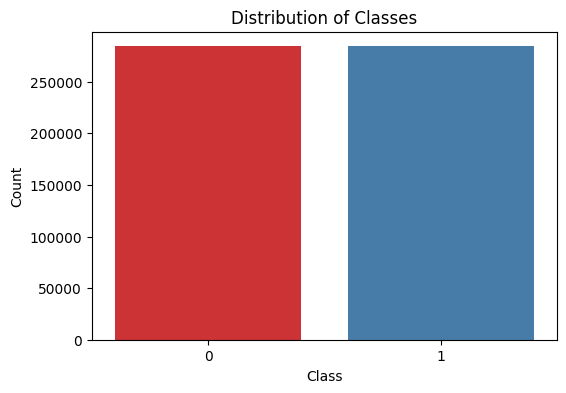

Count of Fraudulent Transactions: 284315
Count of Non-Fraudulent Transactions: 284315


In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=credit_card, palette='Set1')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

fraud_count = (credit_card['Class']==1).sum()
nonfraud_count = (credit_card['Class']==0).sum()
print("Count of Fraudulent Transactions:", fraud_count)
print("Count of Non-Fraudulent Transactions:", nonfraud_count)

In [12]:
credit_card['id'].value_counts()

id
568629    1
0         1
1         1
2         1
3         1
         ..
25        1
26        1
27        1
28        1
29        1
Name: count, Length: 568630, dtype: int64

In [13]:
credit_card[credit_card['Class']==1].count()

id        284315
V1        284315
V2        284315
V3        284315
V4        284315
V5        284315
V6        284315
V7        284315
V8        284315
V9        284315
V10       284315
V11       284315
V12       284315
V13       284315
V14       284315
V15       284315
V16       284315
V17       284315
V18       284315
V19       284315
V20       284315
V21       284315
V22       284315
V23       284315
V24       284315
V25       284315
V26       284315
V27       284315
V28       284315
Amount    284315
Class     284315
dtype: int64

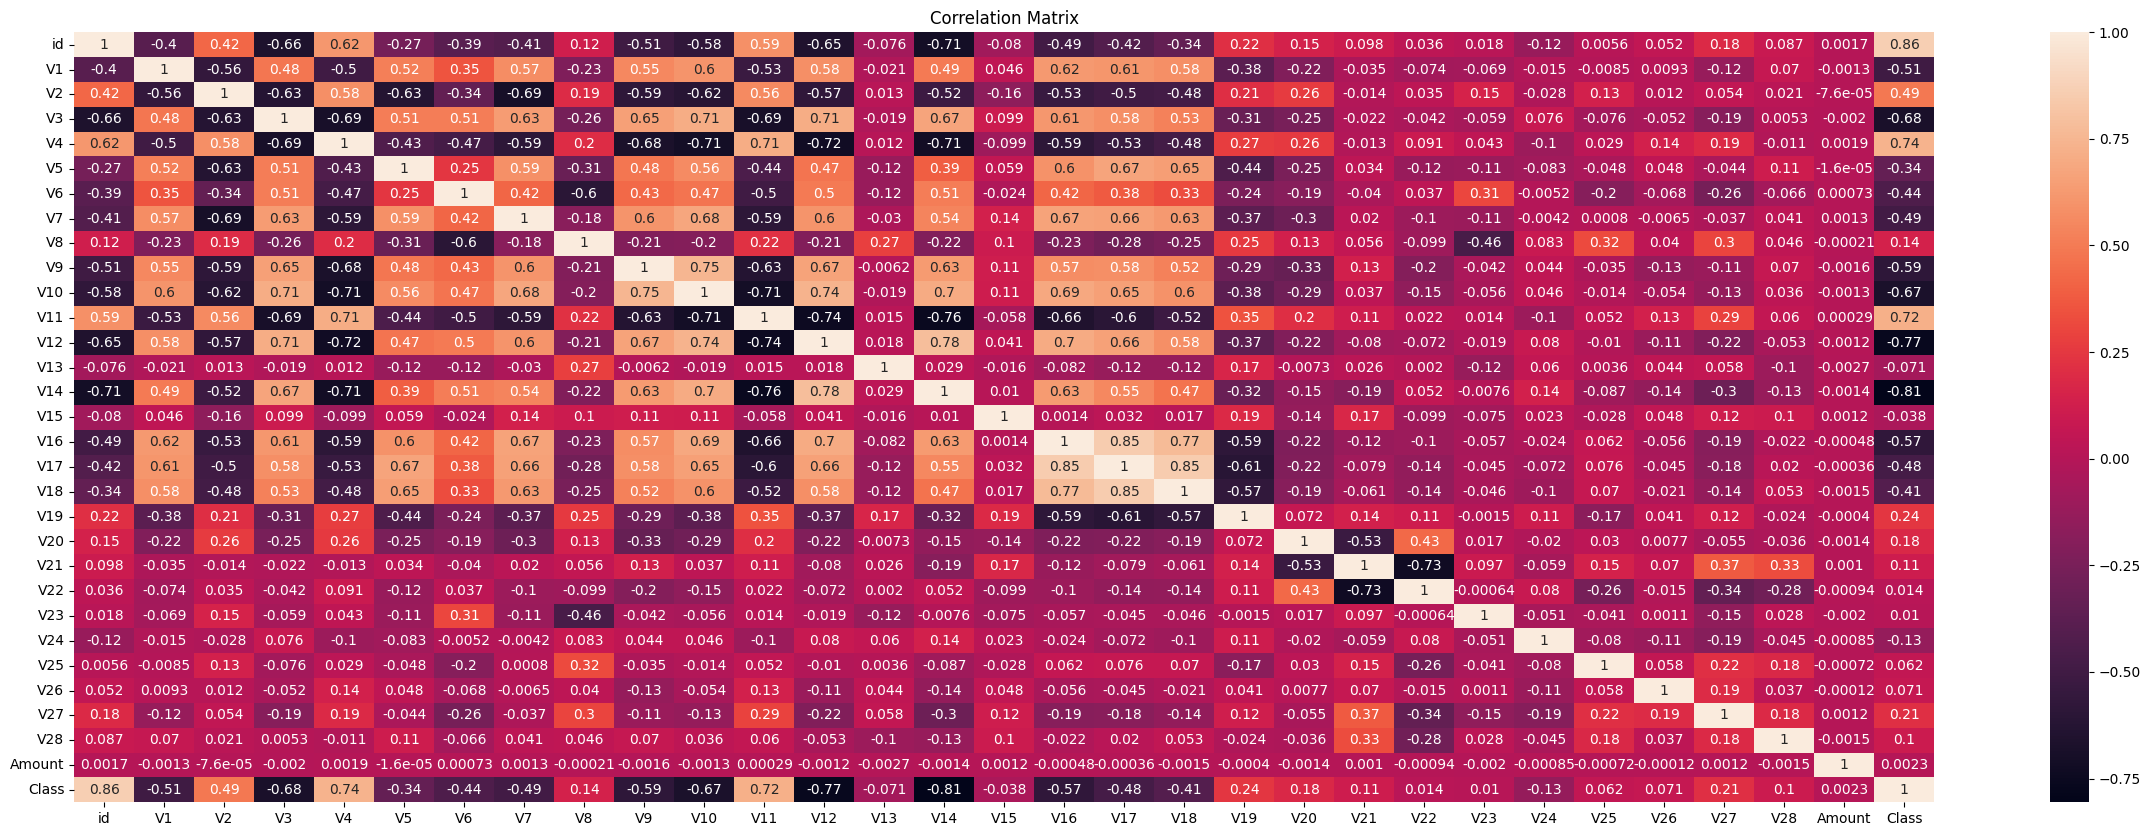

In [14]:
correlations=credit_card.corr()
plt.figure(figsize=(30,10))
sns.heatmap(correlations,annot=True,)
plt.title('Correlation Matrix')
plt.show()

In [15]:
correlations['Class'].sort_values(ascending=False)

Class     1.000000
id        0.864283
V4        0.735981
V11       0.724278
V2        0.491878
V19       0.244081
V27       0.214002
V20       0.179851
V8        0.144294
V21       0.109640
V28       0.102024
V26       0.071052
V25       0.061847
V22       0.014098
V23       0.010255
Amount    0.002261
V15      -0.037948
V13      -0.071105
V24      -0.130107
V5       -0.338639
V18      -0.410091
V6       -0.435088
V17      -0.476377
V7       -0.491234
V1       -0.505761
V16      -0.573511
V9       -0.585522
V10      -0.673665
V3       -0.682095
V12      -0.768579
V14      -0.805669
Name: Class, dtype: float64


# Distribution of V1-V28 and Amount

<Figure size 1000x600 with 0 Axes>

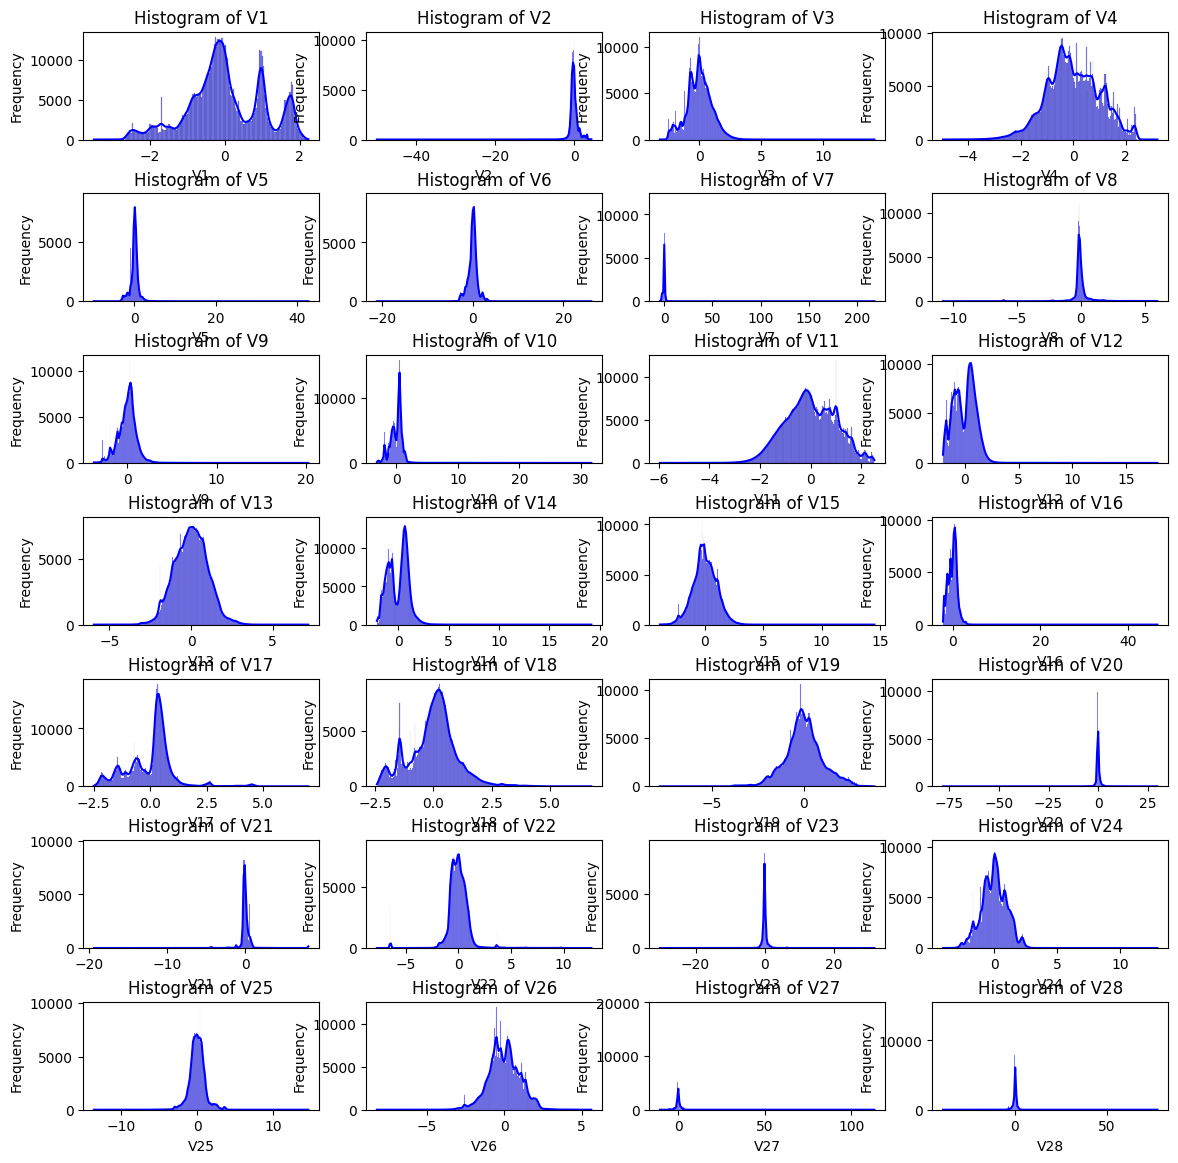

In [16]:
plt.figure(figsize=(10, 6))
columns_to_plot = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


fig, axes = plt.subplots(7, 4, figsize=(14, 14)) # Increased the number of rows in the subplot grid
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(columns_to_plot):
    row_idx = i // 4 # Changed the divisor to match the new number of columns
    col_idx = i % 4

    sns.histplot(data=credit_card, x=col, kde=True, color='blue', ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Histogram of {col}')
    axes[row_idx, col_idx].set_xlabel(col)
    axes[row_idx, col_idx].set_ylabel('Frequency')
plt.show()

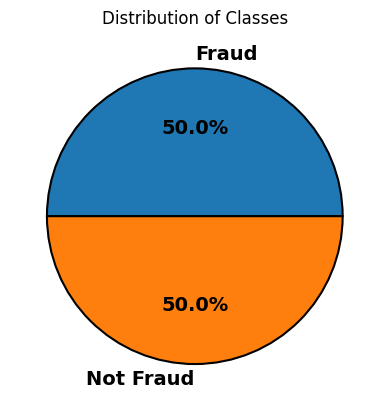

In [17]:
plt.pie(credit_card['Class'].value_counts(), labels=['Fraud', 'Not Fraud'],
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    textprops={'fontsize': 14, 'color': 'black', 'fontweight': 'bold'}, autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.show()

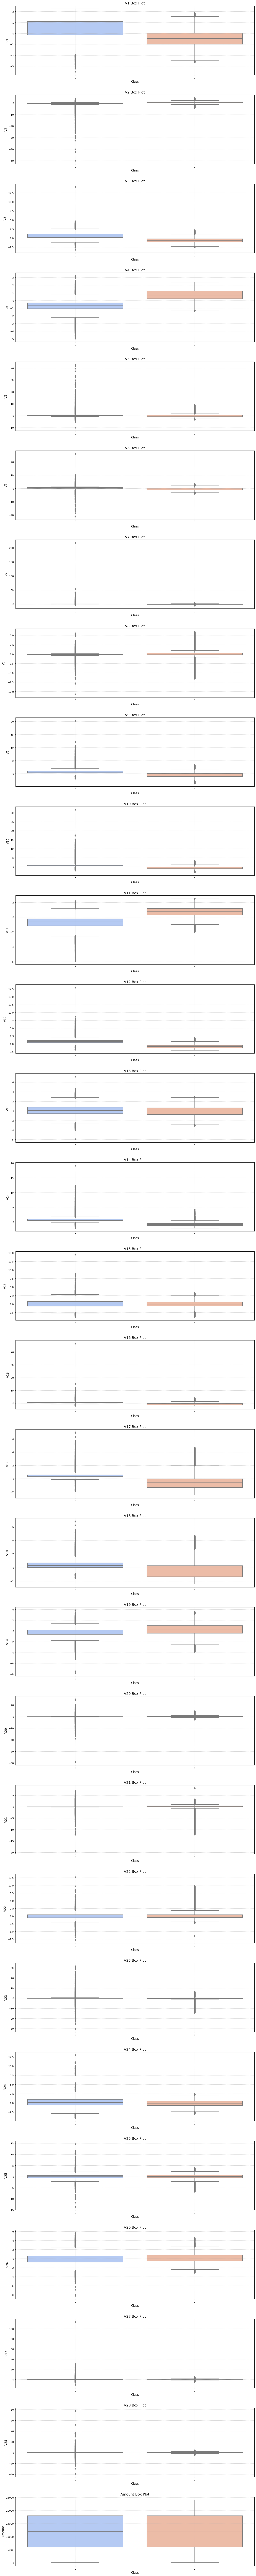

In [21]:
num_variables = credit_card.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in num_variables:
    num_variables.remove('id')
if 'Class' in num_variables:
    num_variables.remove('Class')

fig, ax = plt.subplots(len(num_variables), 1, figsize=(15, 5 * len(num_variables)))

for idx, column in enumerate(num_variables):
    # boxplot
    sns.boxplot(x='Class', y=column, data=credit_card, palette='coolwarm', ax=ax[idx])
    ax[idx].set_title(f"{column} Box Plot", fontsize=14)
    ax[idx].set_xlabel('Class', fontsize=12)
    ax[idx].set_ylabel(column.capitalize(), fontsize=12)
    ax[idx].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(pad=3.0)
plt.show()

In [18]:
x=credit_card.drop(columns=['Class','id'],axis=1)
y=credit_card['Class']

In [19]:
x

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,-1.161847,...,-0.751011,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16
568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,-0.210817,...,-0.550260,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40
568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,-0.144495,...,-0.076417,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85
568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,-0.080078,...,0.288186,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83


In [20]:
y

0         0
1         0
2         0
3         0
4         0
         ..
568625    1
568626    1
568627    1
568628    1
568629    1
Name: Class, Length: 568630, dtype: int64

# Data Rescalling

In [51]:

scaler=StandardScaler()
x_std = scaler.fit_transform(x)
y_std = y

# Split Data 

In [52]:
# split data into train and test set

X_train, X_test, y_train, y_test = train_test_split(x_std, y_std, test_size = 0.2,random_state=42)


# Machine Learning Models

****1.Logistic Regression****

In [23]:
lg=LogisticRegression()
lg.fit(X_train,y_train)
y_lg_predict=lg.predict(X_test)
print(accuracy_score(y_test,y_lg_predict))
print(confusion_matrix(y_test,y_lg_predict))
print(classification_report(y_test,y_lg_predict))

0.9652761901412166
[[55490  1260]
 [ 2689 54287]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56750
           1       0.98      0.95      0.96     56976

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726



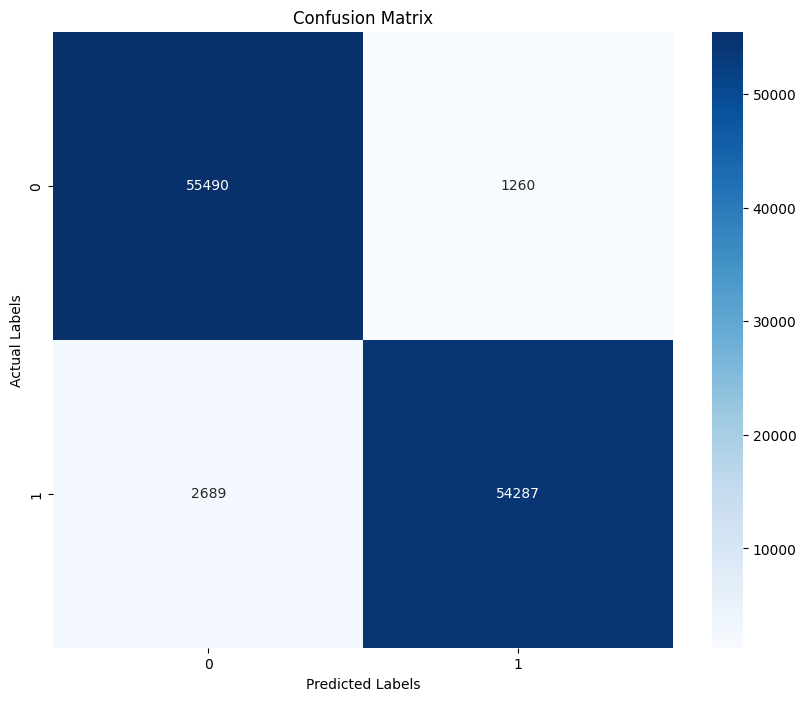

In [48]:

cm = confusion_matrix(y_test, y_lg_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

****2.Descision Tree****

In [45]:
D_tree=DecisionTreeClassifier()
D_tree.fit(X_train,y_train)
y_tree_predict=D_tree.predict(X_test)
print(accuracy_score(y_test,y_tree_predict))
print(confusion_matrix(y_test,y_tree_predict))
print(classification_report(y_test,y_tree_predict))

0.9982677663858748
[[56608   142]
 [   55 56921]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



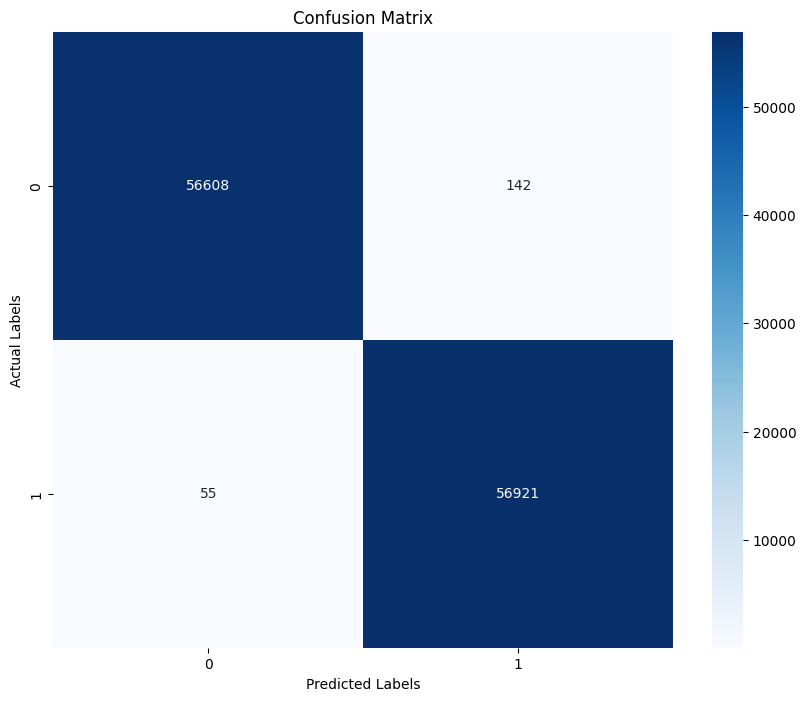

In [47]:
cm = confusion_matrix(y_test, y_tree_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
!pip install pydotplus graphviz==0.20.1

In [ ]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

In [ ]:
features=x.columns
features

In [ ]:
dot_data = StringIO()
export_graphviz(D_tree, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('DT.png')
Image(graph.create_png())

#  Random Forest classifier

In [49]:
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_streams=1)
# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Test Accuracy: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



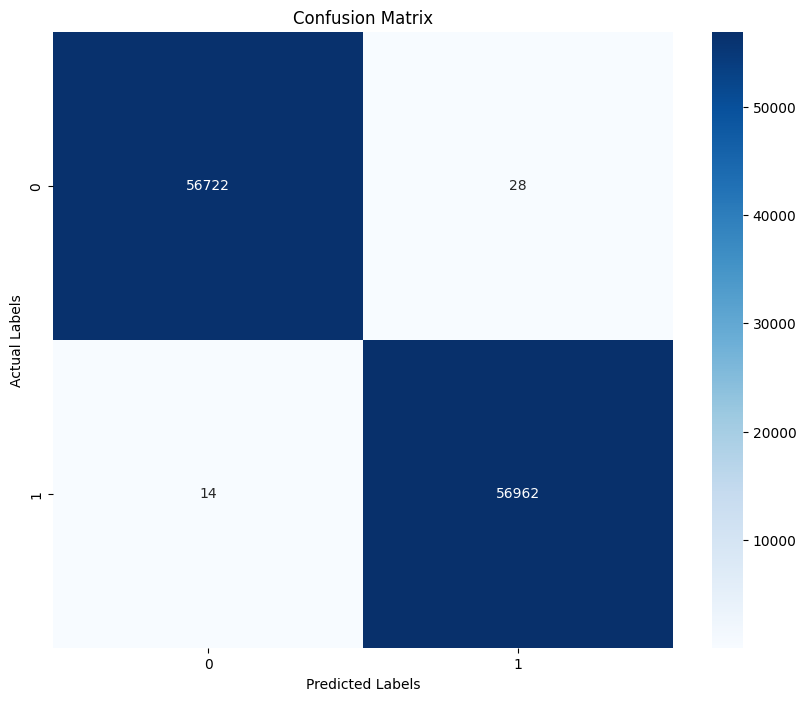

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

# XGBoost classifier

In [51]:
# Define the XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42, tree_method='hist', device='cuda')
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
xgb_y_pred = xgb_classifier.predict(X_test)

# Evaluate the XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f'XGBoost Test Accuracy: {xgb_accuracy:.4f}')

print('XGBoost Classification Report:')
print(classification_report(y_test, xgb_y_pred))

XGBoost Test Accuracy: 0.9997
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:51:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


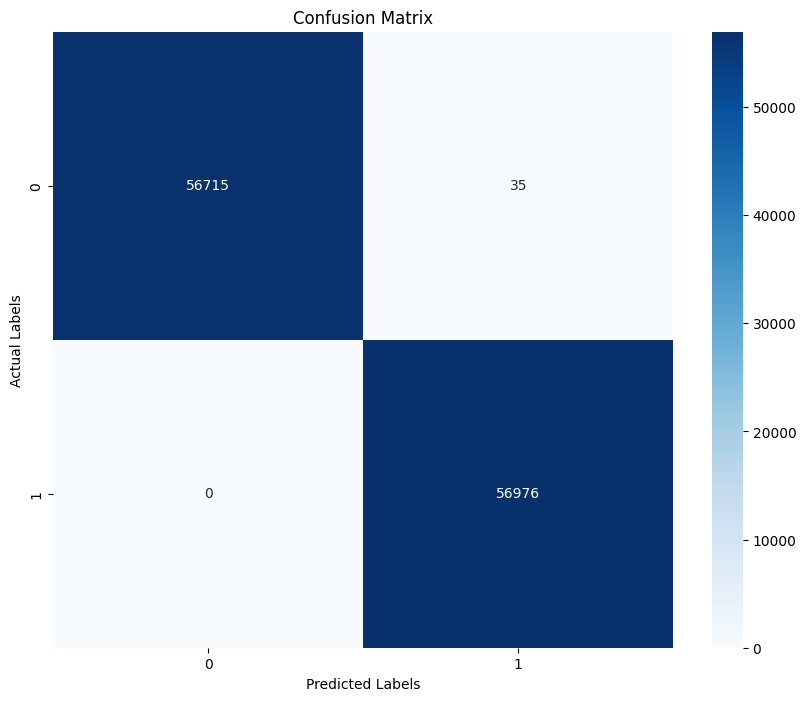

In [52]:
cm = confusion_matrix(y_test,xgb_y_pred )

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC


# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create SVM model
svm_model = SVC(kernel='linear')  # You can experiment with different kernels

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

# Unsupervised Learning with PCA

In [54]:
PCA_model=PCA(n_components=2)
x_pca=PCA_model.fit_transform(x_std)

In [55]:
dfx_trans = PCA_model.transform(x_std)

In [56]:
dfx_trans = pd.DataFrame(data=dfx_trans)
dfx_trans.head(10)

,0,1
0,2.190569,-0.164073
1,2.085246,0.354986
2,2.283198,-0.522378
3,2.694944,0.107422
4,2.048884,-0.354248
5,1.915108,0.238535
6,2.250231,0.233310
7,2.533288,-0.507515
8,2.426936,-0.458912
9,1.993887,0.289736


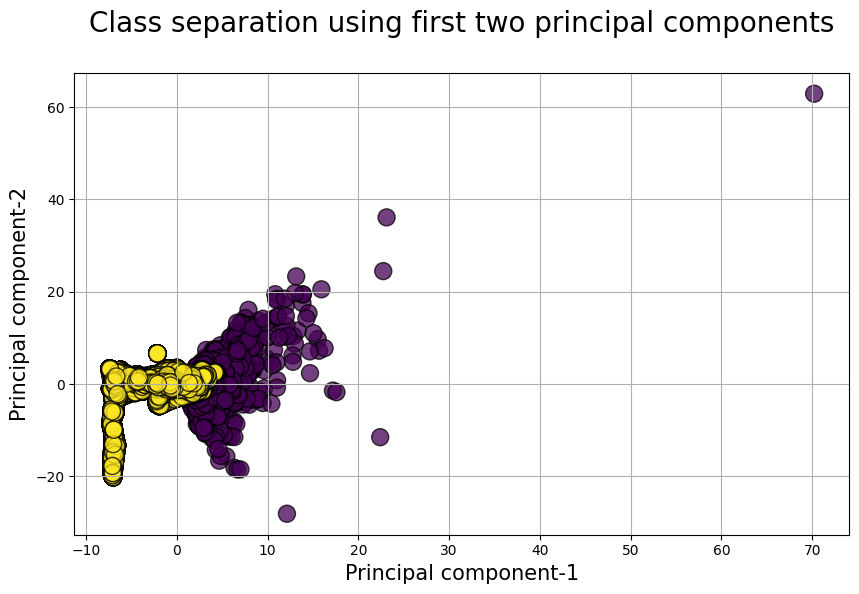

In [57]:
# Plot the first two columns of this transformed data set with the color set to original ground truth class label
plt.figure(figsize=(10,6))
plt.scatter(dfx_trans[0],dfx_trans[1],c=credit_card['Class'],edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

****Descision Tree using PCA**** 

In [58]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(x_pca, y, test_size = 0.2)

In [59]:
D_tree=DecisionTreeClassifier()
D_tree.fit(X_train_pca,y_train)
y_tree_predict=D_tree.predict(X_test_pca)
print(accuracy_score(y_test,y_tree_predict))
print(confusion_matrix(y_test,y_tree_predict))
print(classification_report(y_test,y_tree_predict))

0.9252501626716846
[[52638  4357]
 [ 4144 52587]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     56995
           1       0.92      0.93      0.93     56731

    accuracy                           0.93    113726
   macro avg       0.93      0.93      0.93    113726
weighted avg       0.93      0.93      0.93    113726



****Random Forest Using PCA****

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100,criterion="gini", random_state=42)
rf_classifier.fit(X_train_pca, y_train)
y_pred = rf_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9443
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     56995
           1       0.97      0.92      0.94     56731

    accuracy                           0.94    113726
   macro avg       0.95      0.94      0.94    113726
weighted avg       0.95      0.94      0.94    113726



****Logistic Regression using PCA****

In [62]:
lg=LogisticRegression()
lg.fit(X_train_pca,y_train)
y_lg_predict=lg.predict(X_test_pca)
print(accuracy_score(y_test,y_lg_predict))
print(confusion_matrix(y_test,y_lg_predict))
print(classification_report(y_test,y_lg_predict))

0.9161317552714419
[[56602   393]
 [ 9145 47586]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     56995
           1       0.99      0.84      0.91     56731

    accuracy                           0.92    113726
   macro avg       0.93      0.92      0.92    113726
weighted avg       0.93      0.92      0.92    113726



#  Cross validation K-Fold Method

****Descision Tree after cross validation****

In [53]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

In [54]:

kf=KFold(n_splits=5)


In [27]:
D_tree=DecisionTreeClassifier()
kfold_score = cross_val_score(D_tree,x_std,y,cv=kf)

In [28]:
print("The cross validation scores of k-fold method with 5 folds is",kfold_score)

The cross validation scores of k-fold method with 5 folds is [0.98890315 0.99461864 0.99800397 0.99809191 0.9977226 ]


In [31]:
print("The min accuracy from k-fold CV is",min(kfold_score))
print("The max accuracy from k-fold CV is", max(kfold_score))
print("The mean cross validation scores of k-fold method with 5 folds is",kfold_score_mean)

The min accuracy from k-fold CV is 0.9889031531927616
The max accuracy from k-fold CV is 0.998091905105253
The mean cross validation scores of k-fold method with 5 folds is 0.9954680547983751


****Random Forest after cross validation****

In [32]:
rf_classifier=RandomForestClassifier()
kfold_score = cross_val_score(rf_classifier,x_std,y,cv=kf)

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()


In [33]:
print("The cross validation scores of k-fold method with 5 folds is",kfold_score)

The cross validation scores of k-fold method with 5 folds is [0.99746758 0.99860191 0.99965709 0.99821502 0.99796003]


In [34]:
print("The min accuracy from k-fold CV is",min(kfold_score))
print("The max accuracy from k-fold CV is", max(kfold_score))
print("The mean cross validation scores of k-fold method with 5 folds is",kfold_score_mean)

The min accuracy from k-fold CV is 0.997467577457428
The max accuracy from k-fold CV is 0.9996570944786072
The mean cross validation scores of k-fold method with 5 folds is 0.9954680547983751


****Logistic Regression after cross validation****

In [35]:
lg=LogisticRegression()
kfold_score = cross_val_score(lg,x_std,y,cv=kf)

In [36]:
print("The cross validation scores of k-fold method with 5 folds is",kfold_score)

The cross validation scores of k-fold method with 5 folds is [0.95184918 0.9513216  0.96318344 0.93920476 0.93994337]


In [37]:
print("The min accuracy from k-fold CV is",min(kfold_score))
print("The max accuracy from k-fold CV is", max(kfold_score))
print("The mean cross validation scores of k-fold method with 5 folds is",kfold_score_mean)

The min accuracy from k-fold CV is 0.939204755289028
The max accuracy from k-fold CV is 0.9631834409018166
The mean cross validation scores of k-fold method with 5 folds is 0.9954680547983751


****SVM after cross validation****

In [57]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
selector = SelectKBest(f_classif, k=10)  # Choose the number of features
X_selected = selector.fit_transform(x_std, y)

In [ ]:
# Create and train the SVC model
model = SVC(kernel='linear', C=1.0)  # Adjust parameters as needed
model.fit(x_std, y)

In [ ]:

kfold_score = cross_val_score(model,x_std,y,cv=kf)

In [ ]:
print("The cross validation scores of k-fold method with 5 folds is",kfold_score)

In [ ]:
print("The min accuracy from k-fold CV is",min(kfold_score))
print("The max accuracy from k-fold CV is", max(kfold_score))
print("The mean cross validation scores of k-fold method with 5 folds is",kfold_score_mean)